In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from matplotlib import cm
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from scipy.interpolate import RectBivariateSpline
from scipy.stats import kurtosis, skew
import scipy.optimize as optimize
from iminuit import Minuit

from ipywidgets import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import sncosmo
from sncosmo.salt2utils import BicubicInterpolator

from astropy.table import Table

%matplotlib inline

# Read the data

In [2]:
# file data paths
data_path = ".//SN_surfaces//"
file_names = glob.glob(data_path+"*.dat")
# rewrite the names
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][15:]
print("Total files in path: ", len(file_names))

Total files in path:  160


# To split the test and train dataset

In [3]:
# split our data in training and test dataset with ration 70 - 30 %
np.random.seed(42)
sn_train, sn_test = train_test_split(file_names, test_size=0.3)
print(len(sn_train), len(sn_test))

112 48


In [4]:
#Create a log file with training and testing dataset names
f = open(".//log//train_names.txt", 'w')
for i in range(0, len(sn_train)):
    f.write(str(sn_train[i][:-4])+"\n")
f.close()

f = open(".//log//test_names.txt", 'w')
for i in range(0, len(sn_test)):
    f.write(str(sn_test[i][:-4])+"\n")
f.close()

# Training the model

## Principal Component Analysis

In [5]:
TRAIN_DATASET=[]

# read the training dataset
for i in range(0, len(sn_train)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_train[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TRAIN_DATASET.append(np.array(SN["flux"]))

In [6]:
TRAIN_DATASET

[array([0.62802   , 0.611381  , 0.593151  , ..., 0.0115822 , 0.00991769,
        0.00832076]),
 array([1.59196e-01, 1.91754e-01, 2.22219e-01, ..., 1.58948e-04,
        1.51234e-04, 1.41736e-04]),
 array([0.097077  , 0.117023  , 0.138044  , ..., 0.00133477, 0.00125739,
        0.00117739]),
 array([2.46391e-01, 2.94884e-01, 3.43337e-01, ..., 1.67086e-03,
        9.43364e-04, 3.19163e-04]),
 array([3.18166e-01, 3.38935e-01, 3.56241e-01, ..., 6.94557e-04,
        4.23930e-04, 1.78449e-04]),
 array([1.11545   , 1.05539   , 0.995102  , ..., 0.00640664, 0.006708  ,
        0.00709616]),
 array([ 0.785135  ,  0.748958  ,  0.712496  , ..., -0.00159054,
        -0.00274557, -0.00387855]),
 array([0.195373  , 0.225282  , 0.257926  , ..., 0.00134249, 0.0011237 ,
        0.0010524 ]),
 array([ 0.400705  ,  0.451533  ,  0.496095  , ..., -0.001004  ,
        -0.00152102, -0.0019598 ]),
 array([0.169497  , 0.16467   , 0.159499  , ..., 0.00197001, 0.00175762,
        0.00154208]),
 array([0.138153  , 

In [7]:
def PCA_FIT(dataset, N_comp=10):
    """
    dataset: list containin spectroscopy data
    N_comp: number of components
    """
    np.random.random(42)
    # apply pca with N components
    pca = PCA(N_comp)
    pca.fit(dataset)
    return pca

In [8]:
N=10
pca=PCA_FIT(TRAIN_DATASET, N_comp=N)

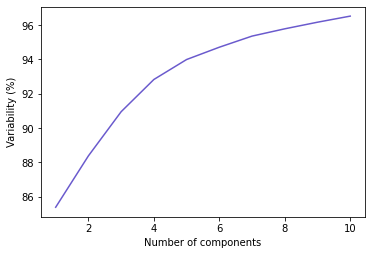

In [9]:
plt.plot(np.linspace(1, 10, 10, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('Number of components')
plt.ylabel('Variability (%)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

#plt.savefig("/home/joao/Desktop/variabilidade_acumulada.png", dpi = 200)   # save the figure to file

In [10]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.9095470928899078


In [11]:
# grid plot
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8000, 451)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

### Mean surface

<ipython-input-12-018f15a35b9b>:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


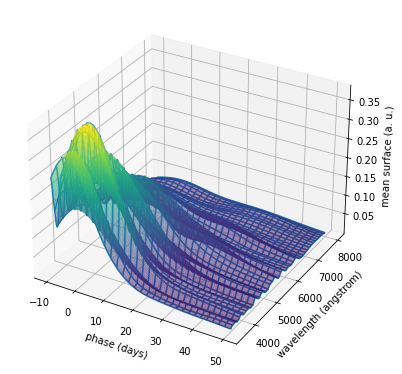

In [12]:
#matplotlib notebook

Z = interp.griddata((SN["phase"],SN["wave"]),pca.mean_,(B1,B2),method='cubic')
#Z = splinemean(B1, B2)
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("wavelength (angstrom)")
ax.set_zlabel("mean surface (a. u.)")

plt.show()

### Components

In [13]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

<ipython-input-14-c2c413a1a0f3>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Out…

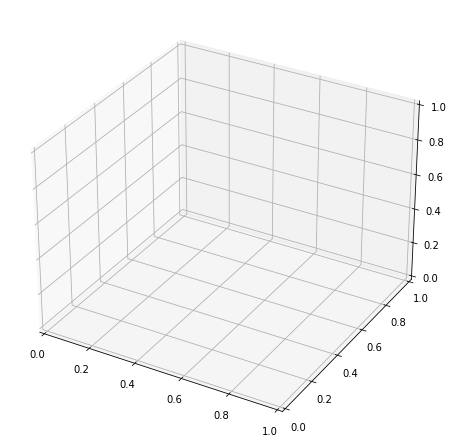

In [14]:
#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()

    Z = interp.griddata((SN["phase"],SN["wave"]),pca.components_[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("wavelength (angstrom)")
    ax.set_zlabel("components (a. u.)")


    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [15]:
# training grid
TEMP_PHASE_GRID = np.linspace(-10, 50, 61, dtype=int)
TEMP_WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [16]:
# 2d grid
X_GRID = []
Y_GRID = []
for i in range(0, len(TEMP_PHASE_GRID)):
    for j in range(0, len(TEMP_WAVE_GRID)):
        X_GRID.append(TEMP_PHASE_GRID[i])
        Y_GRID.append(TEMP_WAVE_GRID[j])

In [17]:
# Templates dataset in a pandas dataframe
templates = []
for i in range(N):
    data = [np.array(X_GRID), np.array(Y_GRID), (pca.components_[i].reshape(501, 61).T).reshape(1, len(pca.components_[i]))[0]] # to save as a pandas dataframe
    templates.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(templates))

number of templates generated:  10


## Mean, Standard Deviation and Skewness

In [18]:
# Mean, Standard Deviation and Skewness surfaces
MEAN = np.mean(TRAIN_DATASET, axis=0)
DESVP = np.std(TRAIN_DATASET, axis=0)
SKW = skew(TRAIN_DATASET, axis=0)

STATISTICAL_MOMENTS = [MEAN, DESVP, SKW]

In [19]:
# Given templates in a pandas dataframe
ST_MOM = []
for i in range(3):
    data = [np.array(X_GRID), np.array(Y_GRID), (STATISTICAL_MOMENTS[i].reshape(501, 61).T).reshape(1, len(STATISTICAL_MOMENTS[i]))[0]] # to save as a pandas dataframe
    ST_MOM.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(ST_MOM))

number of templates generated:  3


# Generate photometry data

In [20]:
# csp filters using sncosmo
ab = sncosmo.get_magsystem('ab')
# catalog of bands
csp_filtersname = ["cspg", "cspr", "cspv9844"]
csp_filters = [sncosmo.get_bandpass('cspg'), sncosmo.get_bandpass('cspr'), sncosmo.get_bandpass('cspv9844')]

In [21]:
# photometry grid
PHOTO_XGRID = np.linspace(-10, 45, 16, dtype=int)
WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [22]:
def function_gen(data, dwave=10, returnfun="on"):
    """
    data: pandas dataframe structured with column names as phase, wave and flux
    dwave: differencial wavelength (defaut 10 angstroms)
    returnfun: variable to define what you will want to return. If on it return function, if off return data values
    """
    
    if returnfun == "on":
        functions = []
        for nn in range(0, len(csp_filters)): # run over filters
            temp_flux = []
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # integral element
                temp_flux.append(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))
            functions.append(Spline1d(PHOTO_XGRID, temp_flux)) # save each function to return (number of functions will be the number of filters)
        return functions

    if returnfun == "off":
        
        temp_phase =[]
        temp_flux = []
        temp_eflux = []
        temp_filter = []
        temp_zp = []
        temp_zpsys = []
        for nn in range(0, len(csp_filters)): # run over filters
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # lists to transform in a pandas dataframe (format of sncosmo fit)
                temp_phase.append(float(PHOTO_XGRID[ii]))
                temp_flux.append(float(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))) # flux
                temp_eflux.append(float(np.sum(csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave*data[data["phase"]==PHOTO_XGRID[ii]]["eflux"]))) # error on flux
                temp_filter.append(str(csp_filtersname[nn])) # given bands
                temp_zp.append(2.5*np.log10(ab.zpbandflux(csp_filtersname[nn]))) # zeropoint magnitudes
                temp_zpsys.append("ab") # magnitude format
                temp_data = [temp_phase, temp_flux, temp_eflux, temp_filter, temp_zp, temp_zpsys] # to save as a pandas dataframe
                temp_data = pd.DataFrame(np.array(temp_data).T, columns=["time", "flux", "fluxerr", "band", "zp", "zpsys"]) # collumn names in agreement with sncosmo
        return temp_data

In [23]:
# Filters dictionary
'''
M0_filt = dict({'cspg':function_gen(templates[0])[0],
                'cspr':function_gen(templates[0])[1],
                'cspv9844':function_gen(templates[0])[2]})

M1_filt = dict({'cspg':function_gen(templates[1])[0],
                'cspr':function_gen(templates[1])[1],
                'cspv9844':function_gen(templates[1])[2]})

M2_filt = dict({'cspg':function_gen(templates[2])[0],
                'cspr':function_gen(templates[2])[1],
                'cspv9844':function_gen(templates[2])[2]})

M3_filt = dict({'cspg':function_gen(templates[3])[0],
                'cspr':function_gen(templates[3])[1],
                'cspv9844':function_gen(templates[3])[2]})

M4_filt = dict({'cspg':function_gen(templates[4])[0],
                'cspr':function_gen(templates[4])[1],
                'cspv9844':function_gen(templates[4])[2]})

M5_filt = dict({'cspg':function_gen(templates[5])[0],
                'cspr':function_gen(templates[5])[1],
                'cspv9844':function_gen(templates[5])[2]})

M6_filt = dict({'cspg':function_gen(templates[6])[0],
                'cspr':function_gen(templates[6])[1],
                'cspv9844':function_gen(templates[6])[2]})

M7_filt = dict({'cspg':function_gen(templates[7])[0],
                'cspr':function_gen(templates[7])[1],
                'cspv9844':function_gen(templates[7])[2]})

M8_filt = dict({'cspg':function_gen(templates[8])[0],
                'cspr':function_gen(templates[8])[1],
                'cspv9844':function_gen(templates[8])[2]})

M9_filt = dict({'cspg':function_gen(templates[9])[0],
                'cspr':function_gen(templates[9])[1],
                'cspv9844':function_gen(templates[9])[2]})
'''

"\nM0_filt = dict({'cspg':function_gen(templates[0])[0],\n                'cspr':function_gen(templates[0])[1],\n                'cspv9844':function_gen(templates[0])[2]})\n\nM1_filt = dict({'cspg':function_gen(templates[1])[0],\n                'cspr':function_gen(templates[1])[1],\n                'cspv9844':function_gen(templates[1])[2]})\n\nM2_filt = dict({'cspg':function_gen(templates[2])[0],\n                'cspr':function_gen(templates[2])[1],\n                'cspv9844':function_gen(templates[2])[2]})\n\nM3_filt = dict({'cspg':function_gen(templates[3])[0],\n                'cspr':function_gen(templates[3])[1],\n                'cspv9844':function_gen(templates[3])[2]})\n\nM4_filt = dict({'cspg':function_gen(templates[4])[0],\n                'cspr':function_gen(templates[4])[1],\n                'cspv9844':function_gen(templates[4])[2]})\n\nM5_filt = dict({'cspg':function_gen(templates[5])[0],\n                'cspr':function_gen(templates[5])[1],\n                'cspv9844':

# Generating Sintetic fotometry on test data

In [24]:
TEST_DATASET=[]
# use the function above
for i in range(0, len(sn_test)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_test[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TEST_DATASET.append(SN)

In [25]:
# photometry data
PHOTOMETRY_DATASET_TEST = []
for i in range(0, len(TEST_DATASET)):
    PHOTOMETRY_DATASET_TEST.append(Table(data=Table.from_pandas(function_gen(TEST_DATASET[i], returnfun="off")), dtype=[float, float, float, str, float, str]))

# Models Fit

### SALT2

In [26]:
def salt2_fit(data):
    # create a model
    model = sncosmo.Model(source='salt2') # sncosmo model (salt2)
    model.set(z=0, t0=0) # fixed params
    # run the fit
    result, fitted_model = sncosmo.fit_lc(data, model, ['x0', 'x1', 'c'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (SALT2): ", result.chisq/result.ndof)
    
    #sncosmo.plot_lc(data, model=fitted_model, errors=result.errors);
    return fitted_model, result

### Single Expansion Model (Using PCA) (com todas 10 componentes)

In [27]:
#from scipy.interpolate import RectBivariateSpline

# A new class for sncosmo
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'c']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  


        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))* 10.** (-0.4 * self._model_ext(wave) * c)

# Light Curve Fits

In [28]:
gridx = np.linspace(-10, 50, 61)
gridy = np.linspace(3500, 8500, 501)

# templates reshaped
M0_reshape = np.array(templates[0]["flux"]).reshape(61, 501) 
M1_reshape = np.array(templates[1]["flux"]).reshape(61, 501)
M2_reshape = np.array(templates[2]["flux"]).reshape(61, 501)
M3_reshape = np.array(templates[3]["flux"]).reshape(61, 501)
M4_reshape = np.array(templates[4]["flux"]).reshape(61, 501)
M5_reshape = np.array(templates[5]["flux"]).reshape(61, 501)
M6_reshape = np.array(templates[6]["flux"]).reshape(61, 501)
M7_reshape = np.array(templates[7]["flux"]).reshape(61, 501)
M8_reshape = np.array(templates[8]["flux"]).reshape(61, 501)
M9_reshape = np.array(templates[9]["flux"]).reshape(61, 501)
c = pd.read_csv(".//Templates//salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]

#exp_mom = EXP_MOM(gridx, gridy, name='EXP_MOM')

## SALT2 x EXP(3)

In [29]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [30]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP4

In [31]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP10

In [32]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## EXP(3)x EXP10

In [33]:
def update_graph(i):
    
    exp3 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    

    exp10 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model10 = sncosmo.Model(source=exp10)

    model10.set(z=0.,
              t0=0,
              c=0)
    
    result_exp10, model_exp10 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model10, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    
    #print(result_exp10.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp3, model_exp10],
                    errors=[result_exp3.errors, result_exp10.errors],
                    model_label=["EXP(3)", "EXP10"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

### SALT2 x EXP(3) with LC (x0, x1, x2, c)

In [34]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'c'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [35]:
def free_parameters(ii):
    """
    i:SN train index
    """
    
    exp = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    
    return result_exp.parameters[2], result_exp.parameters[3], result_exp.parameters[4], result_salt2.parameters[2], result_salt2.parameters[3], result_salt2.parameters[4]

In [36]:
df = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 6)), columns=["x0_exp", "x1_exp", "x2_exp", "x0_salt2", "x1_salt2", "c_salt2"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_salt2, x1_salt2, c_salt2 = free_parameters(i)
    df["x0_exp"][i] = -2.5*np.log10(x0_exp)
    df["x1_exp"][i] = x1_exp
    df["x2_exp"][i] = x2_exp
    df["x0_salt2"][i] = -2.5*np.log10(x0_salt2)
    df["x1_salt2"][i] = x1_salt2
    df["c_salt2"][i] = c_salt2

df.head()

,x0_exp,x1_exp,x2_exp,x0_salt2,x1_salt2,c_salt2
0,16.200745,-0.004749,-0.299546,-10.412894,0.142040,0.051273
1,17.272230,0.062387,-0.120683,-9.138745,1.016078,0.213046
2,15.963347,-0.073469,-0.121175,-10.624340,0.497905,-0.067319
3,16.106418,0.028096,-0.093091,-10.466636,1.855751,-0.023865
4,16.490559,0.022764,-0.272566,-10.128063,-1.750618,0.048524


In [37]:
salt2_param_names = {
    0:"x0_salt2",
    1:"x1_salt2",
    2:"c_salt2"
}

salt2_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$c$"
}

exp_param_names = {
    0:"x0_exp",
    1:"x1_exp",
    2:"x2_exp"
}

exp_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}

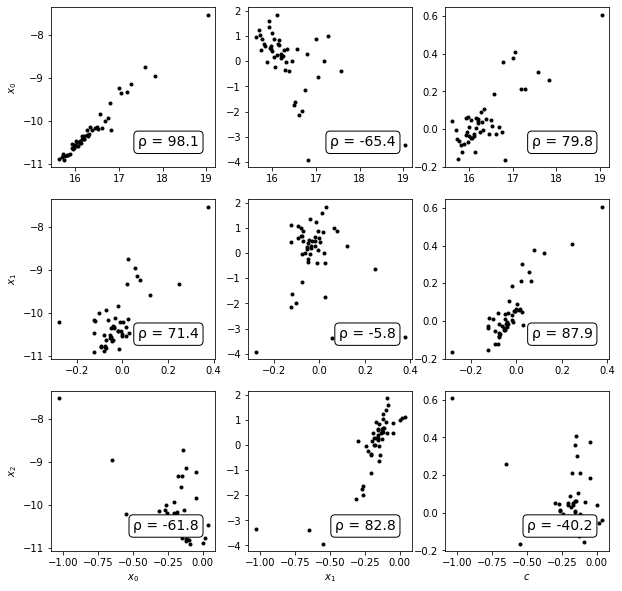

In [38]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        ax[i, j].plot(df[exp_param_names[i]], df[salt2_param_names[j]], 'k.', label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(df[exp_param_names[i]], df[salt2_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp_param_latex[i])
        if i == 2:
            ax[i, j].set_xlabel(salt2_param_latex[j])

## SALT2 x SNEMO2 (with c=0)

In [39]:
#SNEMO2 = pd.read_csv("/home/joao/Documents/Research/SNFACTORY_SNTRAIN/Templates/snemo2/snemo2_ev.dat",
SNEMO2 = pd.read_csv("./Templates/snemo2/snemo2_ev.dat",
                       sep="\s+",
                       names=["time", "wave", "M0", "M1"])
SNEMO2.head()

,time,wave,M0,M1
0,-20.0,3305.0,0.0,0.0
1,-20.0,3317.0,0.0,0.0
2,-20.0,3328.0,0.0,0.0
3,-20.0,3339.0,0.0,0.0
4,-20.0,3350.0,0.0,0.0


In [40]:
SNEMO2["time"].unique()

array([-20., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,
        10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,
        32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,  60.])

In [41]:
gridx_SNEMO = SNEMO2["time"].unique()
gridy_SNEMO= SNEMO2["wave"].unique()

M0_SNEMO2_reshape = np.array(SNEMO2["M0"]).reshape(len(SNEMO2["time"].unique()), len(SNEMO2["wave"].unique()))
M1_SNEMO2_reshape = np.array(SNEMO2["M1"]).reshape(len(SNEMO2["time"].unique()), len(SNEMO2["wave"].unique()))

In [42]:
def update_graph(i):
    
    exp = EXP_LC(gridx_SNEMO, gridy_SNEMO, M0_SNEMO2_reshape, M1_SNEMO2_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x2=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'c'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

# Finding corrrelations between EXP(3) x EXP10 model coefficients 

In [43]:
def parametros_ajustes(ii):
    """
    i:SN train index
    """   
    exp10 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model10 = sncosmo.Model(source=exp10)

    model10.set(z=0.,
              t0=0,
              c=0)

    exp3 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    
        
    model3 = sncosmo.Model(source=exp3)
    model10 = sncosmo.Model(source=exp10)

    model3.set(z=0., t0=0)
    model10.set(z=0., t0=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2'], modelcov=False)
    result_exp10, model_exp10 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model10, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)

    return result_exp3.parameters[2], result_exp3.parameters[3], result_exp3.parameters[4], result_exp10.parameters[2], result_exp10.parameters[3], result_exp10.parameters[4], result_exp10.parameters[5], result_exp10.parameters[6], result_exp10.parameters[7], result_exp10.parameters[8], result_exp10.parameters[9], result_exp10.parameters[10], result_exp10.parameters[11]

In [44]:
param_ajuste = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 13)), columns=["x0_exp3", "x1_exp3", "x2_exp3", "x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_exp10, x1_exp10, x2_exp10, x3_exp10, x4_exp10, x5_exp10, x6_exp10, x7_exp10, x8_exp10, x9_exp10  = parametros_ajustes(i)
    #param_ajuste["x0_exp3"][i] = -2.5*np.log10(x0_exp)
    param_ajuste["x0_exp3"][i] = x0_exp
    param_ajuste["x1_exp3"][i] = x1_exp
    param_ajuste["x2_exp3"][i] = x2_exp
    #param_ajuste["x0_exp10"][i] = -2.5*np.log10(x0_exp10)
    param_ajuste["x0_exp10"][i] = x0_exp10
    param_ajuste["x1_exp10"][i] = x1_exp10
    param_ajuste["x2_exp10"][i] = x2_exp10
    param_ajuste["x3_exp10"][i] = x3_exp10
    param_ajuste["x4_exp10"][i] = x4_exp10
    param_ajuste["x5_exp10"][i] = x5_exp10
    param_ajuste["x6_exp10"][i] = x6_exp10
    param_ajuste["x7_exp10"][i] = x7_exp10
    param_ajuste["x8_exp10"][i] = x8_exp10
    param_ajuste["x9_exp10"][i] = x9_exp10

param_ajuste.head()

,x0_exp3,x1_exp3,x2_exp3,x0_exp10,x1_exp10,x2_exp10,x3_exp10,x4_exp10,x5_exp10,x6_exp10,x7_exp10,x8_exp10,x9_exp10
0,3.309039e-07,-0.004749,-0.299546,2.734483e-07,-0.164070,-0.323013,-0.386377,0.281184,0.100510,0.123915,0.064724,0.131396,-0.019713
1,1.233411e-07,0.062387,-0.120683,9.681849e-08,0.321620,-0.177849,-0.142436,0.199198,0.192323,0.072104,0.150393,0.172476,-0.215897
2,4.117762e-07,-0.073469,-0.121175,3.558933e-07,-0.052146,-0.137914,-0.167518,0.168906,0.058102,0.107233,0.054909,-0.019828,-0.071038
3,3.609380e-07,0.028096,-0.093091,3.218531e-07,-0.154444,-0.227340,-0.248702,0.105317,-0.013657,0.037394,0.029842,-0.003656,0.066665
4,2.533823e-07,0.022764,-0.272566,1.842604e-07,0.278519,-0.293783,-0.109218,0.403107,0.023132,0.192080,0.165892,0.310649,-0.391280


In [45]:
exp3_param_names = {
    0:"x0_exp3",
    1:"x1_exp3",
    2:"x2_exp3"
}

exp3_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}
exp10_param_names = {
    0:"x0_exp10",
    1:"x1_exp10",
    2:"x2_exp10",
    3:"x3_exp10",
    4:"x4_exp10",
    5:"x5_exp10",
    6:"x6_exp10",
    7:"x7_exp10",
    8:"x8_exp10",
    9:"x9_exp10"
}

exp10_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$",
    3:"$x_3$",
    4:"$x_4$",
    5:"$x_5$",
    6:"$x_6$",
    7:"$x_7$",
    8:"$x_8$",
    9:"$x_9$"
}

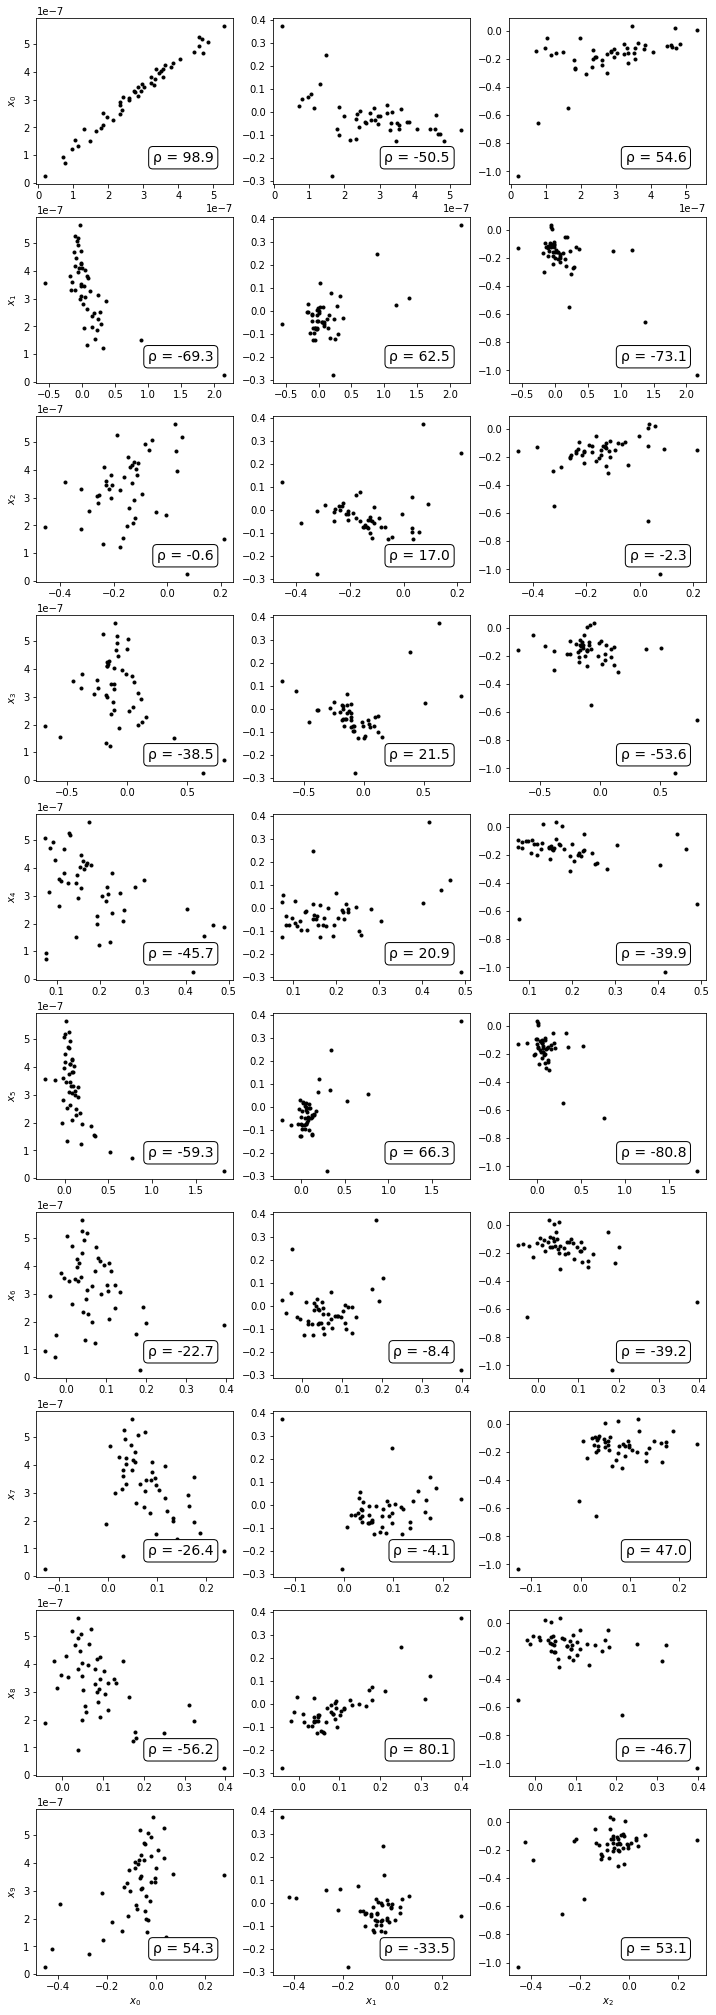

In [46]:
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,36))
for i in range(10):
    for j in range(3):
        ax[i, j].plot(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]], 'k.')#, label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp10_param_latex[i])
        if i == 9:
            ax[i, j].set_xlabel(exp3_param_latex[j])
plt.savefig('correlation.pdf')

In [47]:
correlation_matrix=pd.DataFrame(data=np.zeros(shape=(10, 3)), index=["x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"],columns=["x0_exp3","x1_exp3","x2_exp3"])
for i in range(10):
    for j in range(3):
        correlation_matrix[exp3_param_names[j]][exp10_param_names[i]]=round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1], 4)

In [48]:
correlation_matrix

,x0_exp3,x1_exp3,x2_exp3
x0_exp10,0.9886,-0.5048,0.5465
x1_exp10,-0.6931,0.6248,-0.7308
x2_exp10,-0.0056,0.1697,-0.0230
x3_exp10,-0.3851,0.2149,-0.5364
x4_exp10,-0.4565,0.2090,-0.3992
x5_exp10,-0.5927,0.6633,-0.8078
x6_exp10,-0.2270,-0.0840,-0.3920
x7_exp10,-0.2640,-0.0413,0.4699
x8_exp10,-0.5622,0.8010,-0.4673
x9_exp10,0.5430,-0.3350,0.5312


In [49]:
new_M0=np.zeros(shape=M0_reshape.shape)
new_M1=np.zeros(shape=M1_reshape.shape)
new_M2=np.zeros(shape=M2_reshape.shape)
M=[M0_reshape,M1_reshape,M2_reshape,M3_reshape,M4_reshape,M5_reshape,M6_reshape,M7_reshape,M8_reshape,M9_reshape]
for i in range(10):
    new_M0+=M[i]*correlation_matrix["x0_exp3"][exp10_param_names[i]]
    new_M1+=M[i]*correlation_matrix["x1_exp3"][exp10_param_names[i]]
    new_M2+=M[i]*correlation_matrix["x2_exp3"][exp10_param_names[i]]

## SALT2 x New EXP(3)

In [50]:
def update_graph(i):
    
    exp = EXP_LC(gridx, gridy, new_M0, new_M1, new_M2, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## New EXP(3) x EXP10

In [51]:
def update_graph(i):
    
    exp3 = EXP_LC(gridx, gridy, new_M0, new_M1, new_M2, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    

    exp10 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model10 = sncosmo.Model(source=exp10)

    model10.set(z=0.,
              t0=0,
              c=0)
    
    result_exp10, model_exp10 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model10, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    
    #print(result_exp10.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp3, model_exp10],
                    errors=[result_exp3.errors, result_exp10.errors],
                    model_label=["EXP(3)", "EXP10"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## New EXP(3) x Old EXP(3)

In [52]:
def update_graph(i):
    
    exp3_new = EXP_LC(gridx, gridy, new_M0, new_M1, new_M2, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3_new = sncosmo.Model(source=exp3_new)

    model3_new.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3_new, model_exp3_new = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3_new, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    

    exp3 = EXP_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, c, name='EXP')
    model3 = sncosmo.Model(source=exp3)

    model3.set(z=0.,
              t0=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)
    
    result_exp3, model_exp3 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model3, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    
    #print(result_exp10.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp3_new, model_exp3],
                    errors=[result_exp3_new.errors, result_exp3.errors],
                    model_label=["New EXP(3)", "Old EXP3"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [53]:
new_M0-M0_reshape

array([[ 0.04053728,  0.03153762,  0.02801174, ..., -0.00387376,
        -0.00387391, -0.003874  ],
       [ 0.0384251 ,  0.03166884,  0.02983367, ..., -0.0040071 ,
        -0.00400725, -0.00400734],
       [ 0.03608729,  0.03147886,  0.03114789, ..., -0.00405097,
        -0.00405113, -0.00405122],
       ...,
       [ 0.00612437,  0.00986243,  0.01071273, ..., -0.00110963,
        -0.00110968, -0.0011097 ],
       [ 0.00588643,  0.00956988,  0.01056992, ..., -0.00116641,
        -0.00116647, -0.0011665 ],
       [ 0.00556009,  0.00918542,  0.01031653, ..., -0.0012064 ,
        -0.00120645, -0.00120649]])

## Variance convergency

In [138]:
len(TRAIN_DATASET)

112

In [139]:
N_COMPONENTS = np.linspace(10, 112, 50, dtype=int)

In [140]:
N_training = []
for i in range(0, len(N_COMPONENTS)):
    N_training.append(np.array(random.sample(range(0,112), N_COMPONENTS[i])))

In [141]:
variances = []
templates = []

In [142]:
for i in range(0, len(N_COMPONENTS)):
    new_dataset = []
    for j in range(0, len(N_training[i])):
        for k in range(0, len(TRAIN_DATASET)):
            if k==int(N_training[i][j]):
                new_dataset.append(np.array(TRAIN_DATASET[k]))
                
    temporary_pca=PCA_FIT(new_dataset, N_comp=10)
    variances.append(temporary_pca.explained_variance_ratio_[0]+temporary_pca.explained_variance_ratio_[1]+temporary_pca.explained_variance_ratio_[2])
    templates.append([temporary_pca.components_[0], temporary_pca.components_[1], temporary_pca.components_[2], temporary_pca.components_[3], temporary_pca.components_[4], temporary_pca.components_[5], temporary_pca.components_[6], temporary_pca.components_[7], temporary_pca.components_[8], temporary_pca.components_[9]])

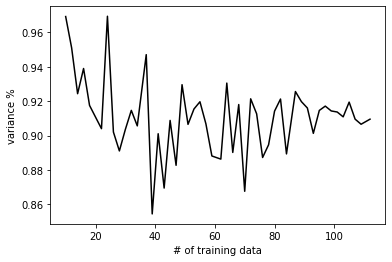

In [143]:
plt.plot(N_COMPONENTS, variances, 'k-')
plt.xlabel("# of training data")
plt.ylabel("variance %");

In [144]:
for i in range(0, len(templates)):
    for j in range(0, len(templates[i])):
        templates[i][j] = (templates[i][j].reshape(501, 61).T).reshape(1, len(templates[i][j]))

In [145]:
mean_chisq = []
for i in range(0, len(templates)):
    print("-----------------", i, "-----------------")
    chisq = []
    for j in range(0, len(PHOTOMETRY_DATASET_TEST)):
        
        comp0_reshape = np.array(templates[i][0]).reshape(61, 501) 
        comp1_reshape = np.array(templates[i][1]).reshape(61, 501)
        comp2_reshape = np.array(templates[i][2]).reshape(61, 501)
        comp3_reshape = np.array(templates[i][3]).reshape(61, 501)
        comp4_reshape = np.array(templates[i][4]).reshape(61, 501)
        comp5_reshape = np.array(templates[i][5]).reshape(61, 501)
        comp6_reshape = np.array(templates[i][6]).reshape(61, 501)
        comp7_reshape = np.array(templates[i][7]).reshape(61, 501)
        comp8_reshape = np.array(templates[i][8]).reshape(61, 501)
        comp9_reshape = np.array(templates[i][9]).reshape(61, 501)

        exp = EXP_LC(gridx, gridy, comp0_reshape, comp1_reshape, comp2_reshape, comp3_reshape, comp4_reshape, comp5_reshape, comp6_reshape, comp7_reshape, comp8_reshape, comp9_reshape, c, name='EXP')
        model = sncosmo.Model(source=exp)

        model.set(z=0.,
              t0=0,
              x3=0,
              x4=0,
              x5=0,
              x6=0,
              x7=0,
              x8=0,
              x9=0,
              c=0)

        result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[j], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
        if result_exp.chisq/result_exp.ndof < 10:
            print(result_exp.chisq/result_exp.ndof)
            chisq.append(result_exp.chisq/result_exp.ndof)   
    mean_chisq.append(np.mean(chisq))

----------------- 0 -----------------
5.970548430316067
2.8943749630854154
0.7115185556062354
2.1419404431064137
7.202566068943338
3.5436042393965117
6.637811171658047
4.767641931606726
2.5637137888065538
3.735611179944924
5.389809739730404
4.728241954114256
5.853798876013254
4.793305822450554
1.9989056095207465
1.001277747926561
6.577338885173218
7.654994452359287
8.058036600936177
9.344806931511993
0.3013894529947874
7.6342644035989125
2.860397666686672
7.112839402307961
7.368727700830618
0.8676968945591331
9.799465383879443
6.873002335492934
1.526792402446857
0.9775147279579348
----------------- 1 -----------------
3.8045143010724396
1.6208429400225979
0.6507992912872151
1.1446769748984442
3.6590047076571426
1.8850815964794436
4.071356984261573
3.223000492560546
1.9846524714773743
4.071887540755016
1.7316066093276352
2.068748650135358
4.489385398606187
3.2565604465617084
5.332541427988952
2.322937491329735
1.8609842683511342
0.4168397245784975
5.8531628816245735
8.463535903786108
5.

9.160234801747594
2.3343362425907843
0.9547928102826884
6.22590203616663
0.7564188831505062
3.3751579589909726
2.068494826372758
1.9583999627678723
4.1991919596951055
1.6275283840896262
1.818744549355897
0.5353522254408735
4.755190625216538
5.294193177617282
7.220884242769052
8.220505819081318
4.256717579542481
2.5950835757460657
6.287861135113925
7.198555117150168
0.21209312864416294
7.197600625844703
4.4258256563447755
1.521690079216985
3.928154476729964
4.243352698281271
0.6155616619476075
7.474302749170043
5.680100859784147
2.749076038791608
4.098737794677025
0.6656809823668596
0.4469859190561302
----------------- 13 -----------------
1.828150781823824
7.173859482751114
0.850852136355471
0.11930440647351631
1.5272392574857412
1.3809097866116082
2.438773235650454
2.0770411596436906
5.774870847960953
1.9785876068380917
0.9830927797251054
7.202411067701519
0.7548134130566805
3.8381452752520824
2.829045651626937
0.9909652824008697
3.124463899826877
1.0996699743905771
1.432959303227682


2.5038464121547626
3.9106981786893975
2.893899712783865
1.469015766381793
6.253432446439547
1.2993473959624438
3.6792930258286907
3.1797970520502323
3.1682952288933155
5.177829219378508
2.810323778043791
2.028257191226312
0.5308837261980426
6.082901776844968
8.652459789244988
8.541889394946391
5.978231227925224
3.4468362398100982
7.900569153657814
9.024968319847135
0.26095682278563953
8.989234270194403
6.023325470247501
2.057247620983946
5.240924776465955
5.931836084997416
0.7500337776369861
6.810866189032377
3.4201886136066983
5.901991424712386
1.0301156040628272
0.6641994589950528
----------------- 25 -----------------
2.8799786813623593
9.848228795083546
1.3308699399312318
0.27648648450475266
1.2945761105981881
2.390532914618701
2.1194461081219136
2.925942740118036
8.592564347463204
2.1025453135400065
1.2801389660117368
5.142640902982082
0.9175827552689555
3.008488612866945
2.8294670626746616
2.091907895405171
3.4211416039799327
1.7353714519012338
1.7468132947038346
0.46180454935965

0.7233713221539098
6.543969990819775
6.690194140986486
8.756339468859172
6.643568690183349
4.114855534060274
8.370427602996015
8.874540161094544
0.3175838601405764
7.242478406264865
1.8838037518487893
6.132985837972057
6.377093216915902
0.8463045791852954
8.835920548669911
4.90769024612523
6.251355247439667
1.1993685677600205
0.7720465190333774
----------------- 36 -----------------
3.9456773173168966
1.6126640565164627
0.36565899144025765
1.7807093494516613
3.076991215296857
2.887005307303587
3.6256160336610996
2.8458333351117164
1.1219534690704465
7.997446945767314
1.1682897845733597
4.142216015801718
2.5730832801041337
2.6645512608902706
5.418104388371732
2.5104524454919392
2.00172314773941
0.6805511275265952
5.786931895843029
7.001052350981398
7.683132640948603
5.356768179722279
7.4760662670930165
8.247479121160904
0.24305358530985852
9.384826673404461
6.042446826019602
1.9383126966199016
4.817387430860056
5.467771134454675
0.7461298284343194
9.032345666312823
7.431251910850384
3.6

9.795820084253908
3.0096520197207703
1.5363867152565824
2.7812696394606373
6.086009861092233
3.6826490878103306
2.2435725404956184
6.712445053616461
3.4521111193144023
1.7878873593149927
1.1811536478126152
5.616937979061384
6.0247727732237255
6.313832895557829
4.690421080375257
4.937405122129384
7.220503250236384
7.950604539488998
0.3163922853777653
7.200127098841857
2.132952209761853
5.733247257249867
5.708120480524456
0.8459743984043745
6.110680361468892
8.93184720963499
5.26128881367323
4.855198936275559
0.8412301924421428
0.7792762980393418
----------------- 47 -----------------
3.484788758474885
9.470190479154235
1.452547945871614
0.17263698989105736
1.7261013357708148
2.741140396270732
3.0030856873742287
3.226711474964409
8.914811083920727
2.2122349750224974
1.163836526928503
8.672468747542249
1.3774097908004248
4.548553829984534
2.8026577808548137
1.882507141115121
4.74611375130354
2.3495794301721133
1.8064410097822423
0.8386212874895768
5.185538327172116
5.531665782661763
6.650

In [146]:
mean_chisq

[4.6963979254320645,
 3.7764245282459377,
 4.744327018371559,
 4.05796986339934,
 3.9691694280915435,
 4.32896180669326,
 3.4587421063420343,
 4.1541665489792425,
 4.117752011817633,
 4.299361469473196,
 4.113444393784418,
 4.5789119468556185,
 3.597913675146604,
 2.8612993092251338,
 4.46714597016465,
 4.710630964501316,
 5.058009289361082,
 3.4816626924250627,
 3.8580195998828426,
 3.5169300536388746,
 3.566842058417772,
 3.389563437733135,
 4.614800485095403,
 4.00541078040072,
 3.9710651281619116,
 3.562196414113089,
 4.200357502796116,
 4.676184642464496,
 2.9896277855061686,
 4.091503842476085,
 4.080134458726562,
 3.9907213902645267,
 4.341717406631622,
 3.859023196108632,
 3.9204575413420852,
 4.253469923516541,
 3.9753275807704163,
 3.909059282317324,
 4.197951688200523,
 4.005223978148664,
 4.287858725734208,
 3.1459594839075846,
 3.958218531254619,
 3.973553793841031,
 3.7620399545105667,
 3.8828566539208977,
 4.280845664988078,
 3.986503358402117,
 4.25294598942739,
 4.1289

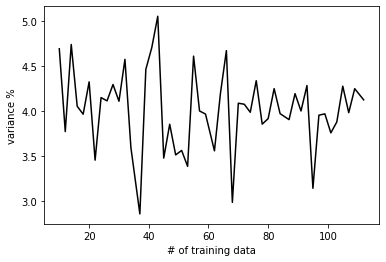

In [149]:
plt.plot(N_COMPONENTS, mean_chisq, 'k-')
plt.xlabel("# of training data")
plt.ylabel("variance %");